# Librerías

In [32]:
from tqdm import tqdm 
import networkx as nx
import scanpy as sc
import pandas as pd
import numpy as np
import pickle 

import seaborn as sns
from scipy.stats import pearsonr

# Funciones auxiliares

In [16]:
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

# Lectura de datos

In [17]:
# ZI Poisson
with open('generados/zi_poisson_dim10000.pkl', 'rb') as f:
    poisson = pickle.load(f)
    X_p = poisson['X'].astype(np.float64)
    y_p = np.array(poisson['y'])
    
# ZI Negative Binomial
with open('generados/zi_negative_binomial_dim10000.pkl', 'rb') as f:
    nb = pickle.load(f)
    X_nb = nb['X'].astype(np.float64)
    y_nb = np.array(nb['y'])

# Pasar a AnnData
anndata_p = sc.AnnData(X_p)
anndata_nb = sc.AnnData(X_nb)

In [18]:
# Normalizamos por size factors
normalize(anndata_p)
normalize(anndata_nb)

AnnData object with n_obs × n_vars = 7875 × 10000
    obs: 'n_counts', 'size_factors'
    var: 'n_counts', 'mean', 'std'
    uns: 'log1p'

In [24]:
# Guardar matrices
X_nb = anndata_nb.X
X_p = anndata_p.X

print(X_nb.shape, X_p.shape)

(7875, 10000) (9513, 10000)


<Axes: >

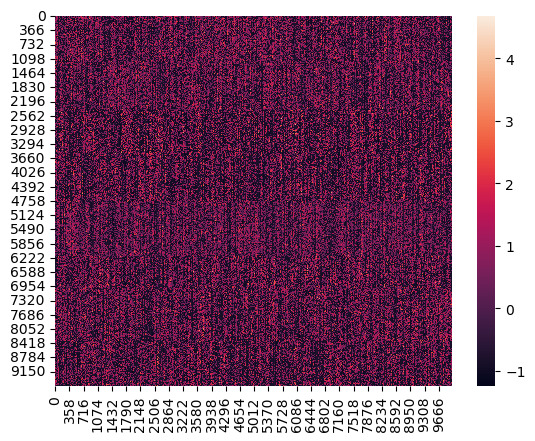

In [23]:
sns.heatmap(X_p)

<Axes: >

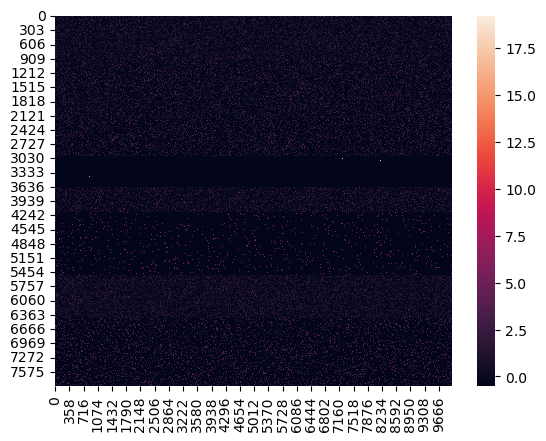

In [22]:
sns.heatmap(X_nb)

# Creación del grafo

In [33]:
def crear_matriz_correlacion(X):
    celulas = X.shape[0]
    correlaciones = np.zeros((celulas,celulas))

    for i in tqdm(range(celulas)):
        for j in range(i, celulas):
            corr, _ = pearsonr(X[i,:], X[j,:])
            correlaciones[i,j] = corr 
            correlaciones[j,i] = corr 

    return correlaciones